# Import Library

In [1]:
!pip install git+https://github.com/onnx/tensorflow-onnx

  Cloning https://github.com/onnx/tensorflow-onnx to /tmp/pip-req-build-c3od3qm1
  Running command git clone --filter=blob:none --quiet https://github.com/onnx/tensorflow-onnx /tmp/pip-req-build-c3od3qm1
  Resolved https://github.com/onnx/tensorflow-onnx to commit 3dd7729e53253e04da079deb56fdce7bb9f4a338
  Preparing metadata (setup.py) ... done


In [87]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, GRU
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import onnx
import tf2onnx
import joblib
import os

# Data Scraping

In [3]:
# List ticker untuk saham 10 perusahaan Indonesia
tickers = ['BBCA.JK', 'BYAN.JK', 'TPIA.JK', 'BBRI.JK', 'BMRI.JK', 'DSSA.JK', 'TLKM.JK', 'ASII.JK', 'BBNI.JK', 'ICBP.JK']

# Download data harga penutupan (adjusted close) untuk setiap perusahaan dengan interval 1 hari
stock_close_datas = {}
stock_open_datas = {}
stock_high_datas = {}
stock_low_datas = {}
stock_volume_datas = {}
for ticker in tickers:
  df = yf.download(ticker, start='2018-01-01', end='2025-05-28', interval='1d')
  stock_open_datas[ticker] = df['Open']
  stock_high_datas[ticker] = df['High']
  stock_low_datas[ticker] = df['Low']
  stock_volume_datas[ticker] = df['Volume']
  stock_close_datas[ticker] = df['Close']

# Gabung semua jadi 1 dataframe
df_all = pd.concat(stock_close_datas, axis=1)
df_all.columns = tickers

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df_all

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926758,716.897949,1457.917725,2289.992676,2592.610107,1390.0,3383.594238,5383.928223,3732.603760,7525.143555
2018-01-02,3723.926758,723.661194,1439.693726,2283.701416,2543.998535,1410.0,3360.731934,5319.062012,3685.475098,7694.249023
2018-01-03,3723.926758,723.661194,1403.245605,2271.118896,2495.387207,1390.0,3223.559326,5221.762207,3553.514648,7694.249023
2018-01-04,3779.189697,716.897949,1348.573730,2233.371826,2535.896973,1390.0,3215.938721,5335.278320,3544.088623,7715.385742
2018-01-05,3783.440674,720.279602,1385.021851,2258.536865,2535.896973,1390.0,3261.663086,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...
2025-05-21,9700.000000,19950.000000,9500.000000,4260.000000,5450.000000,50825.0,2750.000000,4670.000000,4520.000000,10825.000000
2025-05-22,9650.000000,19950.000000,9525.000000,4300.000000,5450.000000,51800.0,2800.000000,4630.000000,4470.000000,10800.000000
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


# Data Preprocessing

## Menangani Missing Value

In [5]:
df_all.isnull().sum()

,0
BBCA.JK,0
BYAN.JK,0
TPIA.JK,0
BBRI.JK,0
BMRI.JK,0
DSSA.JK,0
TLKM.JK,1
ASII.JK,1
BBNI.JK,0
ICBP.JK,1


In [6]:
# Melihat baris yang bernilai null
df_all[df_all.isnull().any(axis=1)]

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2019-06-19,5152.052734,1153.150757,1209.519775,2880.276367,2881.31665,1450.0,NaN,NaN,3534.166504,NaN


Melakukan Forward fill untuk mengisi data yang hilang pada `TLKM.JK`, `ASII.JK`, dan `ICBP.JK`

In [7]:
df_all_ffil = df_all.ffill()
display(df_all_ffil.loc["2019-06-18"])
display(df_all_ffil.loc["2019-06-19"])

,2019-06-18
BBCA.JK,5117.358887
BYAN.JK,1160.313232
TPIA.JK,1202.114502
BBRI.JK,2860.134033
BMRI.JK,2836.155029
DSSA.JK,1450.000000
TLKM.JK,3145.500732
ASII.JK,5101.784668
BBNI.JK,3464.674561
ICBP.JK,9077.743164


,2019-06-19
BBCA.JK,5152.052734
BYAN.JK,1153.150757
TPIA.JK,1209.519775
BBRI.JK,2880.276367
BMRI.JK,2881.316650
DSSA.JK,1450.000000
TLKM.JK,3145.500732
ASII.JK,5101.784668
BBNI.JK,3534.166504
ICBP.JK,9077.743164


In [8]:
df_all_ffil.shape

(1820, 10)

In [9]:
df_all_ffil.isnull().sum()

,0
BBCA.JK,0
BYAN.JK,0
TPIA.JK,0
BBRI.JK,0
BMRI.JK,0
DSSA.JK,0
TLKM.JK,0
ASII.JK,0
BBNI.JK,0
ICBP.JK,0


## Menangani Tanggal yang Terlewat dengan Forward Fill

Dilakukan Pengecekan terhadap berapa banyak hari yang tidak terdapat dalam data

In [10]:
full_date_range = pd.date_range(start=df_all_ffil.index.min(), end=df_all_ffil.index.max(), freq='D')
df_all_ffil.index = pd.to_datetime(df_all_ffil.index)

existing_dates = df_all_ffil.index.unique()

existing_dates_index = pd.DatetimeIndex(existing_dates)

missing_dates = full_date_range.difference(existing_dates_index)
print(f"Jumlah tanggal yang hilang: {missing_dates.size}")

Jumlah tanggal yang hilang: 884


Melakukan Forward Fill untuk mengisi tanggal yang hilang dengan cara menyebarkan data nilai terakhir yang diketahui ke depan hingga nilai berikutnya yang tidak hilang

In [11]:
df_all_ffil = df_all_ffil.reindex(full_date_range).ffill()
df_all_ffil.index.name = 'Date'
df_all_ffil

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926758,716.897949,1457.917725,2289.992676,2592.610107,1390.0,3383.594238,5383.928223,3732.603760,7525.143555
2018-01-02,3723.926758,723.661194,1439.693726,2283.701416,2543.998535,1410.0,3360.731934,5319.062012,3685.475098,7694.249023
2018-01-03,3723.926758,723.661194,1403.245605,2271.118896,2495.387207,1390.0,3223.559326,5221.762207,3553.514648,7694.249023
2018-01-04,3779.189697,716.897949,1348.573730,2233.371826,2535.896973,1390.0,3215.938721,5335.278320,3544.088623,7715.385742
2018-01-05,3783.440674,720.279602,1385.021851,2258.536865,2535.896973,1390.0,3261.663086,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


Melakukan pengecekan apakah tanggal yang hilang sudah berhasil diisi semuanya

In [12]:
full_date_range = pd.date_range(start=df_all_ffil.index.min(), end=df_all_ffil.index.max(), freq='D')
df_all_ffil.index = pd.to_datetime(df_all_ffil.index)

existing_dates = df_all_ffil.index.unique()

existing_dates_index = pd.DatetimeIndex(existing_dates)

missing_dates = full_date_range.difference(existing_dates_index)
print(f"Jumlah tanggal yang hilang: {missing_dates.size}")

Jumlah tanggal yang hilang: 0


## Mengganti Nama Kolom

In [13]:
df_all_ffil.columns = df_all_ffil.columns.str.replace('.JK', '', regex=False)
df_all_ffil

,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
Date,,,,,,,,,,
2018-01-01,3723.926758,716.897949,1457.917725,2289.992676,2592.610107,1390.0,3383.594238,5383.928223,3732.603760,7525.143555
2018-01-02,3723.926758,723.661194,1439.693726,2283.701416,2543.998535,1410.0,3360.731934,5319.062012,3685.475098,7694.249023
2018-01-03,3723.926758,723.661194,1403.245605,2271.118896,2495.387207,1390.0,3223.559326,5221.762207,3553.514648,7694.249023
2018-01-04,3779.189697,716.897949,1348.573730,2233.371826,2535.896973,1390.0,3215.938721,5335.278320,3544.088623,7715.385742
2018-01-05,3783.440674,720.279602,1385.021851,2258.536865,2535.896973,1390.0,3261.663086,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...
2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000


## Menambah Fitur Tanggal

Dilakukan pengubahan data tanggal dari index menjadi kolom date

In [14]:
df_all_ffil = df_all_ffil.reset_index()
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926758,716.897949,1457.917725,2289.992676,2592.610107,1390.0,3383.594238,5383.928223,3732.603760,7525.143555
1,2018-01-02,3723.926758,723.661194,1439.693726,2283.701416,2543.998535,1410.0,3360.731934,5319.062012,3685.475098,7694.249023
2,2018-01-03,3723.926758,723.661194,1403.245605,2271.118896,2495.387207,1390.0,3223.559326,5221.762207,3553.514648,7694.249023
3,2018-01-04,3779.189697,716.897949,1348.573730,2233.371826,2535.896973,1390.0,3215.938721,5335.278320,3544.088623,7715.385742
4,2018-01-05,3783.440674,720.279602,1385.021851,2258.536865,2535.896973,1390.0,3261.663086,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...,...
2699,2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2700,2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2701,2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2702,2025-05-26,9625.000000,19975.000000,9750.000000,4320.000000,5475.000000,53900.0,2800.000000,4730.000000,4500.000000,11025.000000


## Menangani Duplikasi Data

In [15]:
print("Jumlah duplikasi data:", df_all_ffil.duplicated().sum())

Jumlah duplikasi data: 0


## Mengurutkan data

Karena data yang dibutuhkan merupakan data time series, maka datanya harus berurutan berdasarkan waktu (Kolom `Date`)

In [16]:
df_all_ffil = df_all_ffil.sort_values(by="Date", ascending=True)
df_all_ffil

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926758,716.897949,1457.917725,2289.992676,2592.610107,1390.0,3383.594238,5383.928223,3732.603760,7525.143555
1,2018-01-02,3723.926758,723.661194,1439.693726,2283.701416,2543.998535,1410.0,3360.731934,5319.062012,3685.475098,7694.249023
2,2018-01-03,3723.926758,723.661194,1403.245605,2271.118896,2495.387207,1390.0,3223.559326,5221.762207,3553.514648,7694.249023
3,2018-01-04,3779.189697,716.897949,1348.573730,2233.371826,2535.896973,1390.0,3215.938721,5335.278320,3544.088623,7715.385742
4,2018-01-05,3783.440674,720.279602,1385.021851,2258.536865,2535.896973,1390.0,3261.663086,5383.928223,3506.385254,7842.214844
...,...,...,...,...,...,...,...,...,...,...,...
2699,2025-05-23,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2700,2025-05-24,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2701,2025-05-25,9675.000000,19975.000000,10550.000000,4350.000000,5425.000000,52700.0,2690.000000,4740.000000,4510.000000,10825.000000
2702,2025-05-26,9625.000000,19975.000000,9750.000000,4320.000000,5475.000000,53900.0,2800.000000,4730.000000,4500.000000,11025.000000


# Data Exploration

## Deskripsi Variabel

Setiap kolom berisi harga saham penutupan (adjusted close) dari top 20 emiten Indonesia

In [17]:
df_all_ffil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704 entries, 0 to 2703
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2704 non-null   datetime64[ns]
 1   BBCA    2704 non-null   float64       
 2   BYAN    2704 non-null   float64       
 3   TPIA    2704 non-null   float64       
 4   BBRI    2704 non-null   float64       
 5   BMRI    2704 non-null   float64       
 6   DSSA    2704 non-null   float64       
 7   TLKM    2704 non-null   float64       
 8   ASII    2704 non-null   float64       
 9   BBNI    2704 non-null   float64       
 10  ICBP    2704 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 232.5 KB


Terdapat nilai null pada beberapa kolom

In [18]:
df_all_ffil.describe()

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
count,2704,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000,2704.000000
mean,2021-09-13 12:00:00,6647.044846,7508.757341,3075.294014,3323.686692,3496.613422,7859.921413,3128.445697,4521.508741,3383.968309,9258.538798
min,2018-01-01 00:00:00,3529.552734,591.778931,1093.920776,1513.757202,1411.886963,920.000000,2070.656250,2251.151367,1292.781372,6683.181152
25%,2019-11-07 18:00:00,5111.655762,1164.566650,1722.659546,2546.369019,2476.076416,1497.500000,2766.273682,4184.782227,2789.608887,8028.595703
50%,2021-09-13 12:00:00,6205.836914,1432.485352,2247.613770,3233.821167,2806.314453,2212.500000,3029.644897,4564.072266,3421.679932,9129.916992
75%,2023-07-21 06:00:00,8451.990234,17800.613770,2599.425049,3979.260803,4483.701050,5000.000000,3534.067383,4890.241089,3988.644043,10396.153320
max,2025-05-27 00:00:00,10570.414062,22548.173828,10625.000000,5763.100098,6769.004883,53900.000000,4295.701172,5738.722656,5460.848145,12800.000000
std,NaN,1897.875962,8006.582769,2358.763383,936.935362,1349.876990,12444.669658,471.635287,633.273770,899.857006,1393.909421


## Analisis Harga Saham Tiap Perusahaan

In [19]:
dates = df_all_ffil['Date']
stocks = df_all_ffil.drop(columns='Date')

<Figure size 1400x600 with 0 Axes>

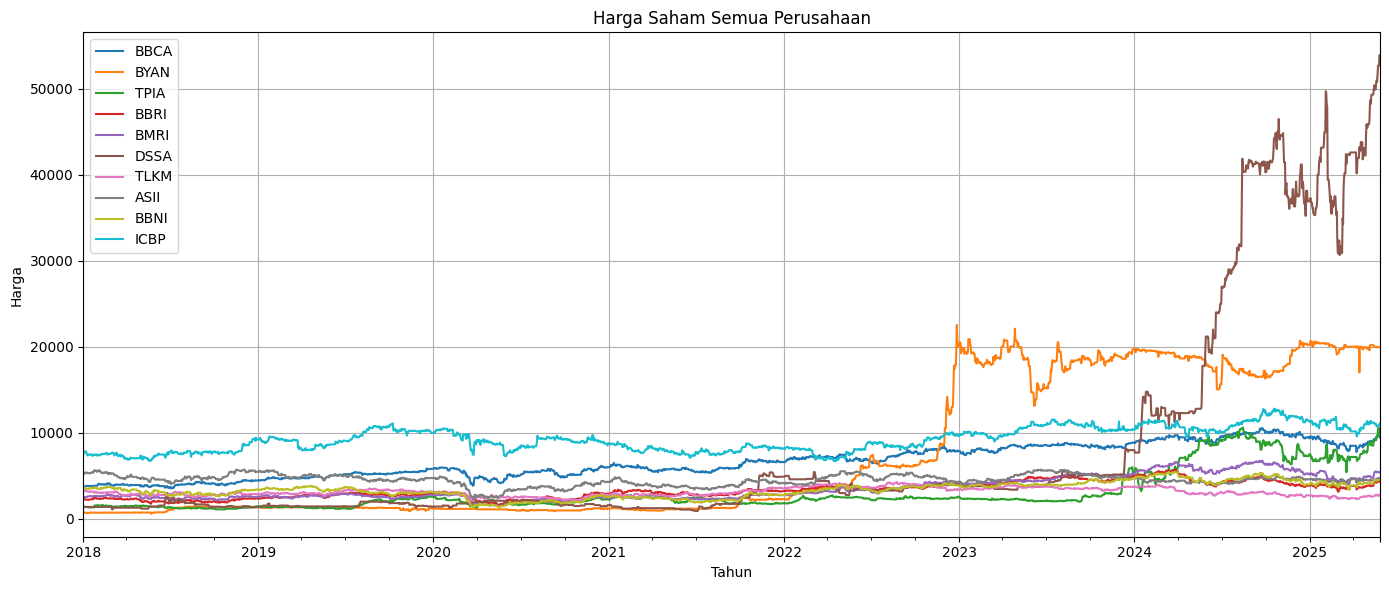

In [20]:
plt.figure(figsize=(14, 6))
stocks.index = dates  # ubah dates jadi index
stocks.plot(figsize=(14, 6))
plt.ylabel("Harga")
plt.xlabel("Tahun")
plt.title("Harga Saham Semua Perusahaan")
plt.grid(True)
plt.tight_layout()
plt.show()

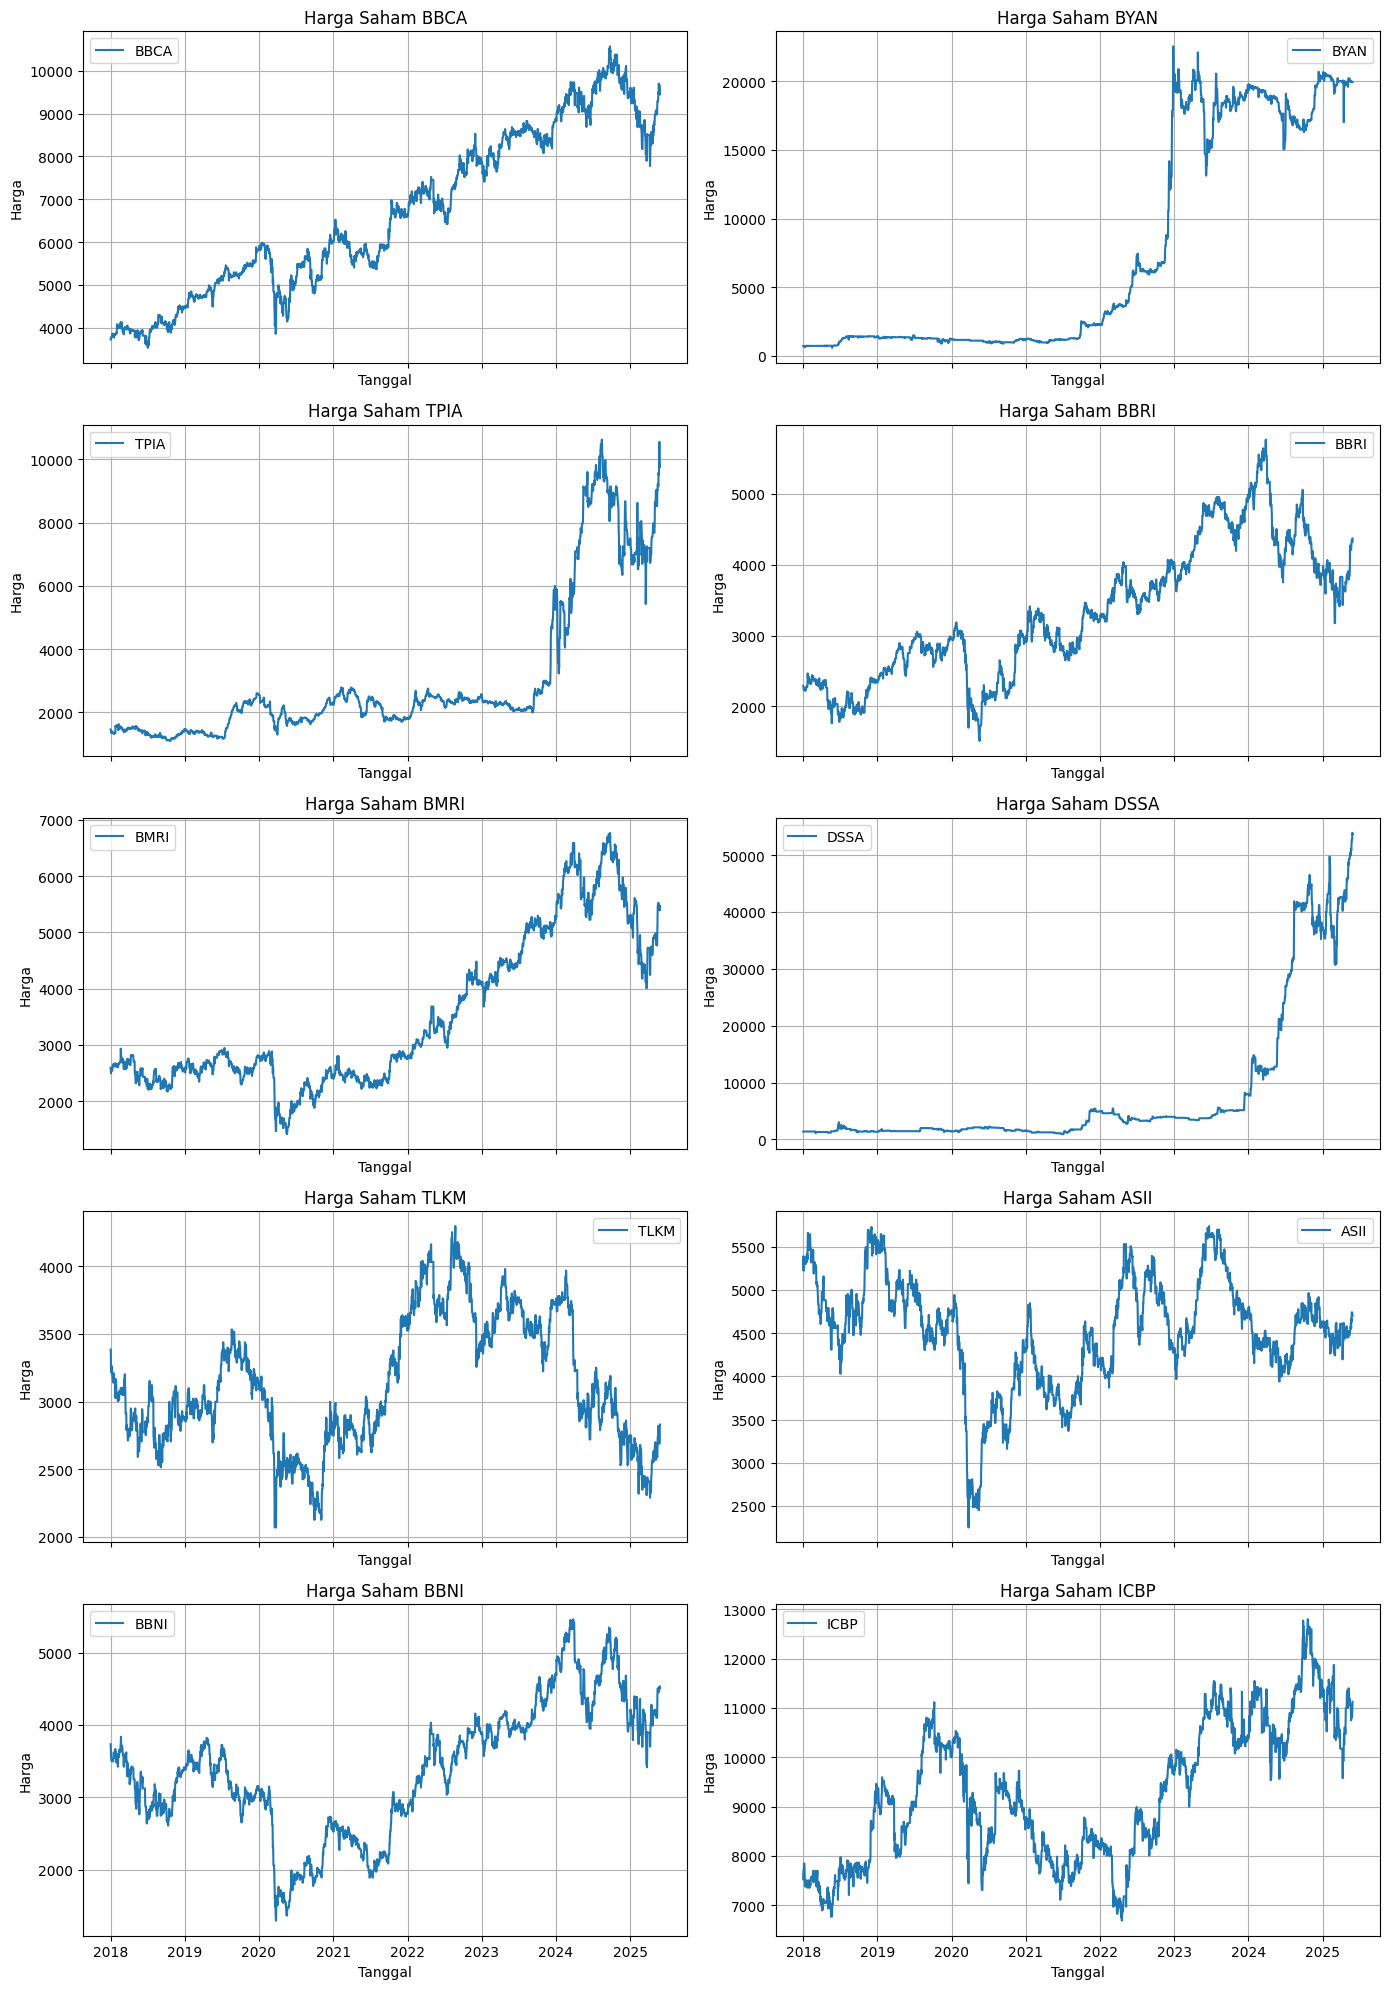

In [21]:
num_stocks = len(stocks.columns)
cols = 2  # jumlah kolom subplot
rows = (num_stocks + cols - 1) // cols  # jumlah baris yang dibutuhkan

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()  # ubah axes jadi array datar agar mudah diakses

for i, stock in enumerate(stocks.columns):
    axes[i].plot(dates, stocks[stock], label=stock)
    axes[i].set_title(f"Harga Saham {stock}")
    axes[i].set_ylabel("Harga")
    axes[i].set_xlabel("Tanggal")
    axes[i].legend()
    axes[i].grid(True)

# Sembunyikan subplot kosong jika jumlah saham ganjil
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Korelasi Antar Saham

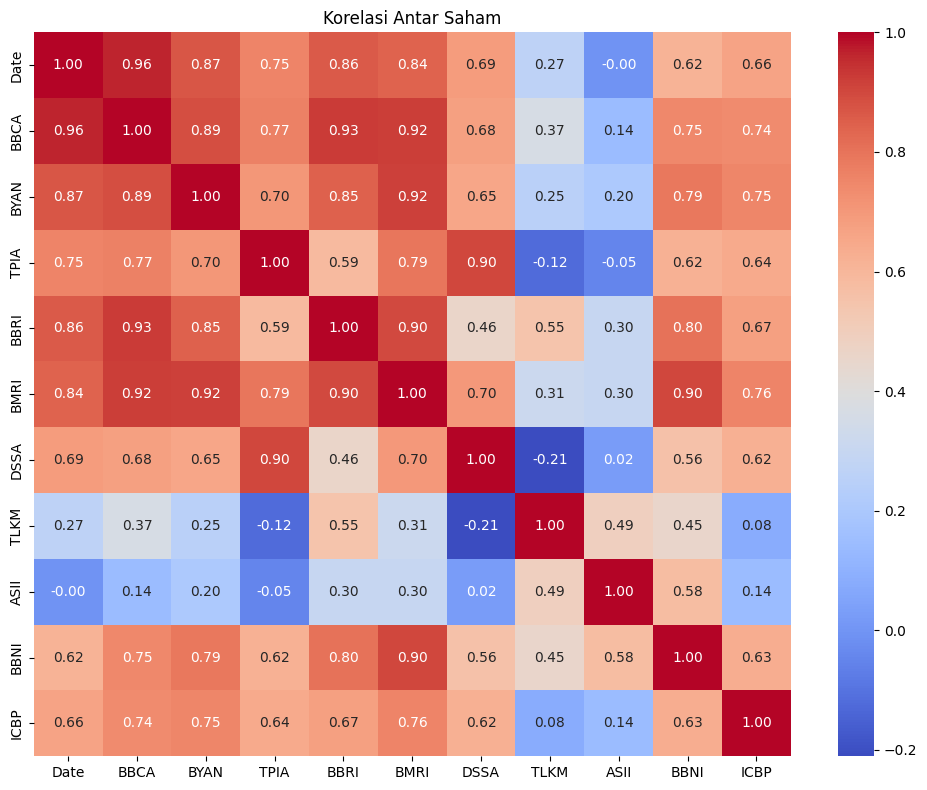

In [22]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_all_ffil.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Saham")
plt.tight_layout()
plt.show()

# Data Preparation

## Simpan Data ke Format CSV

In [23]:
# Saving data to csv
df_all_ffil.to_csv("stocks.csv", index=False)

## Standarisasi Data

In [24]:
# Asumsikan df_all_ffil sudah tersedia
df = df_all_ffil.copy()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Simpan nama saham
tickers = df.columns.tolist()

# Simpan hasil standarisasi
scalers = {ticker: StandardScaler() for ticker in tickers}
df_scaled = pd.DataFrame(index=df.index)

# Standarisasi per kolom
for ticker in tickers:
    df_scaled[ticker] = scalers[ticker].fit_transform(df[[ticker]])

## Windowing

In [25]:
def create_sliding_window(data, window_size=30, horizon=1):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size + horizon - 1])
    return np.array(X), np.array(y)

## Splitting Data

In [26]:
# Split rasio: 70% train, 15% eval, 15% test
train_ratio = 0.7
eval_ratio = 0.15

def split_data(data, window_size, horizon):
    X, y = create_sliding_window(data, window_size, horizon)
    n = len(X)
    train_end = int(n * train_ratio)
    eval_end = train_end + int(n * eval_ratio)

    return (X[:train_end], y[:train_end],
            X[train_end:eval_end], y[train_end:eval_end],
            X[eval_end:], y[eval_end:])

# Modeling

## BBCA

In [27]:
window_size = 30
horizon = 1

data_bbca = df_scaled['BBCA'].values
X_train_bbca, y_train_bbca, X_val_bbca, y_val_bbca, X_test_bbca, y_test_bbca = split_data(data_bbca, window_size, horizon)

model_bbca = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(1)
])

model_bbca.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_bbca.summary()
print("Model input shape:", model_bbca.input_shape)
print("Model output shape:", model_bbca.output_shape)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [28]:
history_bbca = model_bbca.fit(X_train_bbca[..., np.newaxis], y_train_bbca,
              validation_data=(X_val_bbca[..., np.newaxis], y_val_bbca),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - loss: 0.1749 - mape: 61.7991 - val_loss: 0.1466 - val_mape: 12.9100
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0617 - mape: 46.2445 - val_loss: 0.0782 - val_mape: 6.8886
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.0551 - mape: 40.6418 - val_loss: 0.0637 - val_mape: 5.6822
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 0.0457 - mape: 27.1929 - val_loss: 0.0529 - val_mape: 4.8397
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0424 - mape: 29.0908 - val_loss: 0.0505 - val_mape: 4.6426
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - loss: 0.0417 - mape: 23.6418 - val_loss: 0.0490 - val_mape: 4.5206
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - loss: 0.0413 - mape: 26.3790 - val_loss: 0.0469 - val_mape: 4.3909
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - loss: 0.0396 - mape: 20.9352 - val_loss: 0.0470 - val_mape: 4.3320
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━

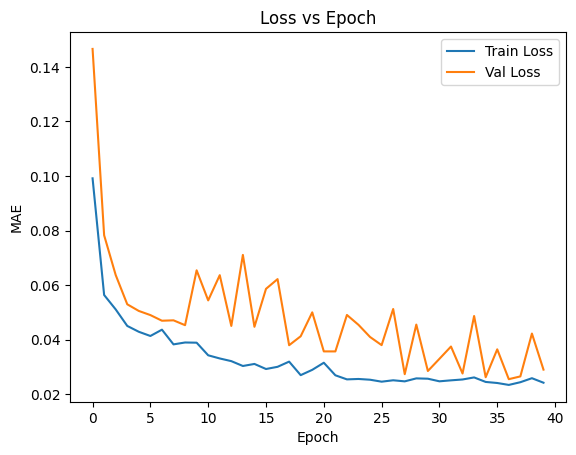

In [29]:
plt.plot(history_bbca.history['loss'], label='Train Loss')
plt.plot(history_bbca.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [30]:
y_pred_bbca = model_bbca.predict(X_test_bbca[..., np.newaxis]).flatten()
scaler_bbca = scalers['BBCA']
y_pred_unscaled_bbca = scaler_bbca.inverse_transform(y_pred_bbca.reshape(-1, 1)).flatten()
y_test_unscaled_bbca = scaler_bbca.inverse_transform(y_test_bbca.reshape(-1, 1)).flatten()

mae_bbca = mean_absolute_error(y_test_unscaled_bbca, y_pred_unscaled_bbca)
rmse_bbca = np.sqrt(mean_squared_error(y_test_unscaled_bbca, y_pred_unscaled_bbca))
mape_bbca = mean_absolute_percentage_error(y_test_unscaled_bbca, y_pred_unscaled_bbca) * 100

print('MAE Data Test BBCA : ', mae_bbca)
print('RMSE Data Test BBCA: ', rmse_bbca)
print('MAPE Data Test BBCA: ', mape_bbca)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
MAE Data Test BBCA :  98.68511446672886
RMSE Data Test BBCA:  133.8786704172427
MAPE Data Test BBCA:  1.0531019212147243


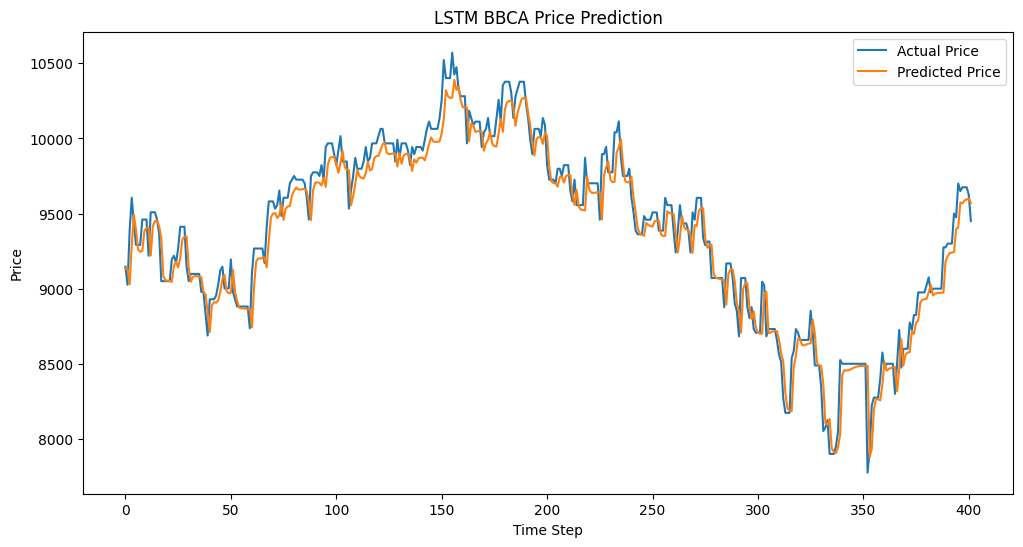

In [31]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_bbca, label='Actual Price')
plt.plot(y_pred_unscaled_bbca, label='Predicted Price')
plt.title('LSTM BBCA Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [32]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_bbca = data_bbca[-365:]

pred_dict_bbca = {}
for label, steps in time_span.items():
    X = recent_data_bbca.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_bbca.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_bbca = scaler_bbca.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_bbca[label] = float(unscaled_pred_bbca)

pred_dict_bbca

{'1d': 9438.642423340978,
 '1w': 9324.801437775968,
 '1m': 8898.887039004898,
 '3m': 8272.90717977436,
 '6m': 7767.638531660881}

## BYAN

In [33]:
window_size = 30
horizon = 1

data_byan = df_scaled['BYAN'].values
X_train_byan, y_train_byan, X_val_byan, y_val_byan, X_test_byan, y_test_byan = split_data(data_byan, window_size, horizon)

model_byan = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_byan.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_byan.summary()
print("Model input shape:", model_byan.input_shape)
print("Model output shape:", model_byan.output_shape)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [34]:
history_byan = model_byan.fit(X_train_byan[..., np.newaxis], y_train_byan,
              validation_data=(X_val_byan[..., np.newaxis], y_val_byan),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.2604 - mape: 40.9203 - val_loss: 0.0789 - val_mape: 6.2224
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0250 - mape: 8.6594 - val_loss: 0.0649 - val_mape: 5.3948
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0198 - mape: 6.0328 - val_loss: 0.0616 - val_mape: 5.0163
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0182 - mape: 5.7983 - val_loss: 0.0579 - val_mape: 4.7551
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0168 - mape: 4.7363 - val_loss: 0.0786 - val_mape: 5.9608
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0224 - mape: 6.5757 - val_loss: 0.0541 - val_mape: 4.3990
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0172 - mape: 6.5674 - val_loss: 0.0659 - val_mape: 5.0652
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0181 - mape: 5.2927 - val_loss: 0.0508 - val_mape: 4.1256
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/s

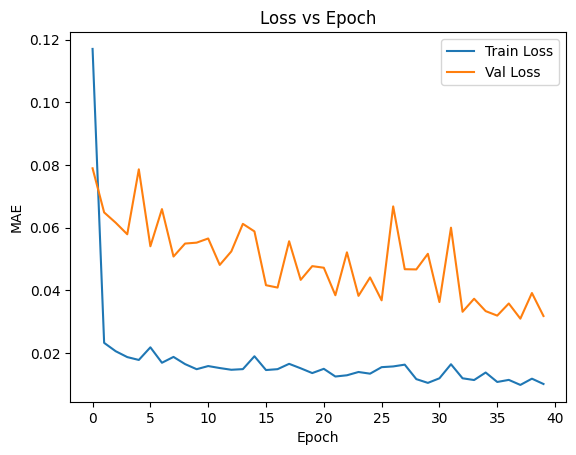

In [35]:
plt.plot(history_byan.history['loss'], label='Train Loss')
plt.plot(history_byan.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [36]:
y_pred_byan = model_byan.predict(X_test_byan[..., np.newaxis]).flatten()
scaler_byan = scalers['BYAN']
y_pred_unscaled_byan = scaler_byan.inverse_transform(y_pred_byan.reshape(-1, 1)).flatten()
y_test_unscaled_byan = scaler_byan.inverse_transform(y_test_byan.reshape(-1, 1)).flatten()

mae_byan = mean_absolute_error(y_test_unscaled_byan, y_pred_unscaled_byan)
rmse_byan = np.sqrt(mean_squared_error(y_test_unscaled_byan, y_pred_unscaled_byan))
mape_byan = mean_absolute_percentage_error(y_test_unscaled_byan, y_pred_unscaled_byan) * 100

print('MAE Data Test BYAN : ', mae_byan)
print('RMSE Data Test BYAN: ', rmse_byan)
print('MAPE Data Test BYAN: ', mape_byan)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
MAE Data Test BYAN :  257.02736075481965
RMSE Data Test BYAN:  385.111002081606
MAPE Data Test BYAN:  1.3794754197290109


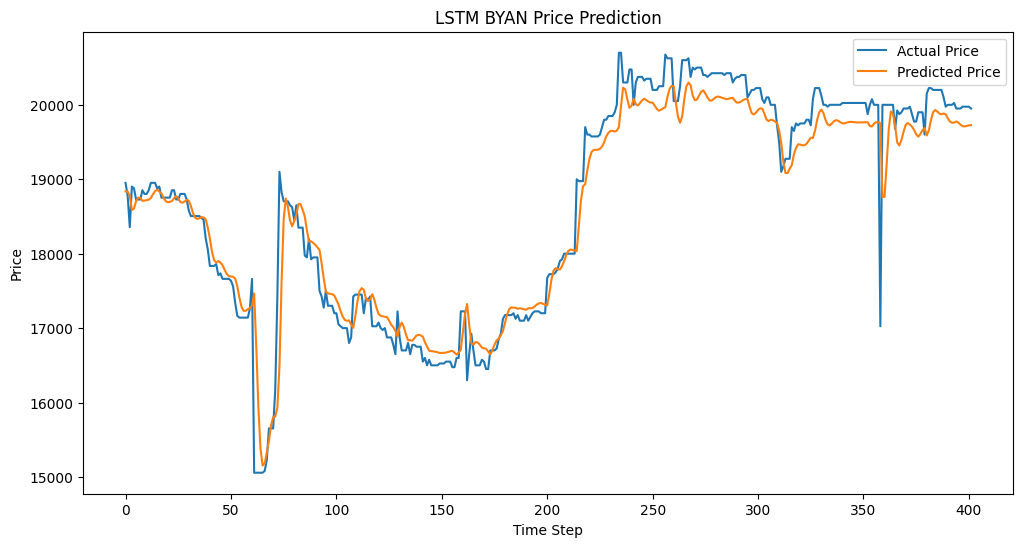

In [37]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_byan, label='Actual Price')
plt.plot(y_pred_unscaled_byan, label='Predicted Price')
plt.title('LSTM BYAN Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [38]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_byan = data_byan[-365:]

pred_dict_byan = {}
for label, steps in time_span.items():
    X = recent_data_byan.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_byan.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_byan = scaler_byan.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_byan[label] = float(unscaled_pred_byan)

pred_dict_byan

{'1d': 19714.88221102023,
 '1w': 19191.242571544186,
 '1m': 18352.17056511091,
 '3m': 18234.940772553105,
 '6m': 18236.486710263278}

## TPIA

In [39]:
window_size = 30
horizon = 1

data_tpia = df_scaled['TPIA'].values
X_train_tpia, y_train_tpia, X_val_tpia, y_val_tpia, X_test_tpia, y_test_tpia = split_data(data_tpia, window_size, horizon)

model_tpia = Sequential([
    Input(shape=(window_size, 1)),
    GRU(128, return_sequences=True),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

model_tpia.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_tpia.summary()
print("Model input shape:", model_tpia.input_shape)
print("Model output shape:", model_tpia.output_shape)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [40]:
history_tpia = model_tpia.fit(X_train_tpia[..., np.newaxis], y_train_tpia,
              validation_data=(X_val_tpia[..., np.newaxis], y_val_tpia),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - loss: 0.1405 - mape: 30.3952 - val_loss: 0.0767 - val_mape: 17.7846
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0388 - mape: 8.7987 - val_loss: 0.0648 - val_mape: 15.9123
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.0351 - mape: 7.8417 - val_loss: 0.0612 - val_mape: 16.2178
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0360 - mape: 8.0007 - val_loss: 0.0591 - val_mape: 13.8810
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.0330 - mape: 7.4942 - val_loss: 0.0636 - val_mape: 17.1067
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0343 - mape: 7.5254 - val_loss: 0.0730 - val_mape: 15.0761
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 0.0306 - mape: 6.6874 - val_loss: 0.0536 - val_mape: 12.1921
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 0.0294 - mape: 6.6259 - val_loss: 0.0593 - val_mape: 12.7876
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 

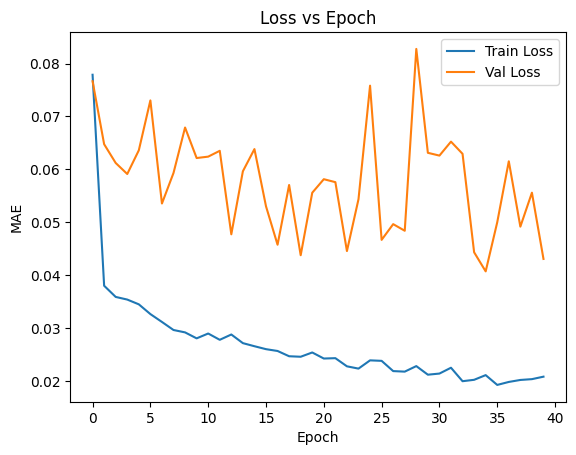

In [41]:
plt.plot(history_tpia.history['loss'], label='Train Loss')
plt.plot(history_tpia.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [42]:
y_pred_tpia = model_tpia.predict(X_test_tpia[..., np.newaxis]).flatten()
scaler_tpia = scalers['TPIA']
y_pred_unscaled_tpia = scaler_tpia.inverse_transform(y_pred_tpia.reshape(-1, 1)).flatten()
y_test_unscaled_tpia = scaler_tpia.inverse_transform(y_test_tpia.reshape(-1, 1)).flatten()

mae_tpia = mean_absolute_error(y_test_unscaled_tpia, y_pred_unscaled_tpia)
rmse_tpia = np.sqrt(mean_squared_error(y_test_unscaled_tpia, y_pred_unscaled_tpia))
mape_tpia = mean_absolute_percentage_error(y_test_unscaled_tpia, y_pred_unscaled_tpia) * 100

print('MAE Data Test TPIA : ', mae_tpia)
print('RMSE Data Test TPIA: ', rmse_tpia)
print('MAPE Data Test TPIA: ', mape_tpia)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
MAE Data Test TPIA :  609.6682541880441
RMSE Data Test TPIA:  701.3641905333595
MAPE Data Test TPIA:  7.179994965878015


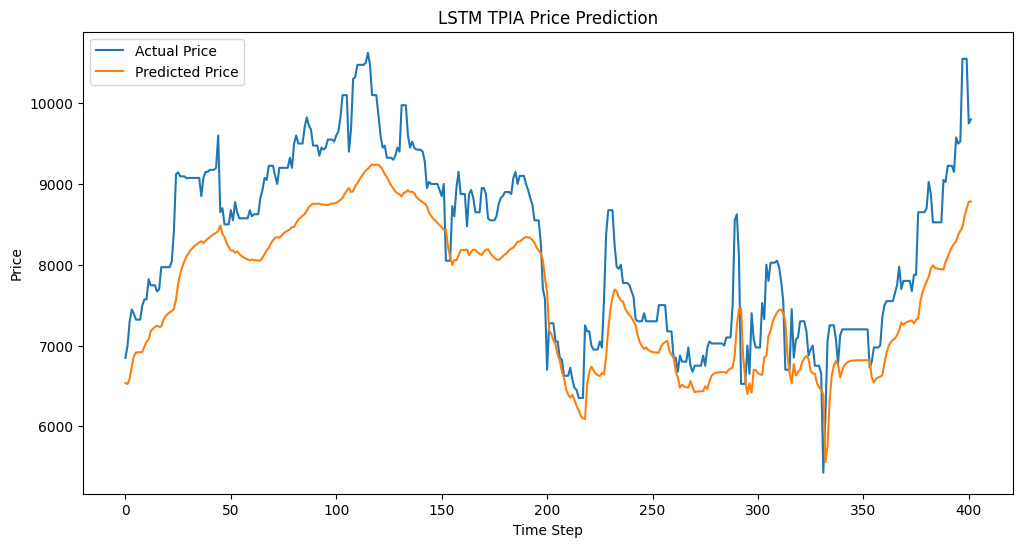

In [43]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_tpia, label='Actual Price')
plt.plot(y_pred_unscaled_tpia, label='Predicted Price')
plt.title('LSTM TPIA Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [44]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_tpia = data_tpia[-365:]

pred_dict_tpia = {}
for label, steps in time_span.items():
    X = recent_data_tpia.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_tpia.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_tpia = scaler_tpia.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_tpia[label] = float(unscaled_pred_tpia)

pred_dict_tpia

{'1d': 8738.432678492258,
 '1w': 8038.2840548780505,
 '1m': 4624.856816778667,
 '3m': 3260.049146411847,
 '6m': 3231.2101577504804}

## BBRI

In [45]:
window_size = 30
horizon = 1

data_bbri = df_scaled['BBRI'].values
X_train_bbri, y_train_bbri, X_val_bbri, y_val_bbri, X_test_bbri, y_test_bbri = split_data(data_bbri, window_size, horizon)

model_bbri = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_bbri.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_bbri.summary()
print("Model input shape:", model_bbri.input_shape)
print("Model output shape:", model_bbri.output_shape)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [46]:
history_bbri = model_bbri.fit(X_train_bbri[..., np.newaxis], y_train_bbri,
              validation_data=(X_val_bbri[..., np.newaxis], y_val_bbri),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.3050 - mape: 104.9449 - val_loss: 0.6297 - val_mape: 38.1515
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0782 - mape: 56.7740 - val_loss: 0.4003 - val_mape: 23.3575
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0691 - mape: 48.6457 - val_loss: 0.4008 - val_mape: 23.6455
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0612 - mape: 41.9058 - val_loss: 0.4043 - val_mape: 24.0343
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0617 - mape: 33.3348 - val_loss: 0.3598 - val_mape: 21.0872
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0548 - mape: 29.9782 - val_loss: 0.2962 - val_mape: 16.9839
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0542 - mape: 43.3239 - val_loss: 0.2449 - val_mape: 13.8468
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0522 - mape: 33.9371 - val_loss: 0.2475 - val_mape: 14.0476
Epoch 9/40
59/59 ━━━━━━━━━━━━━━

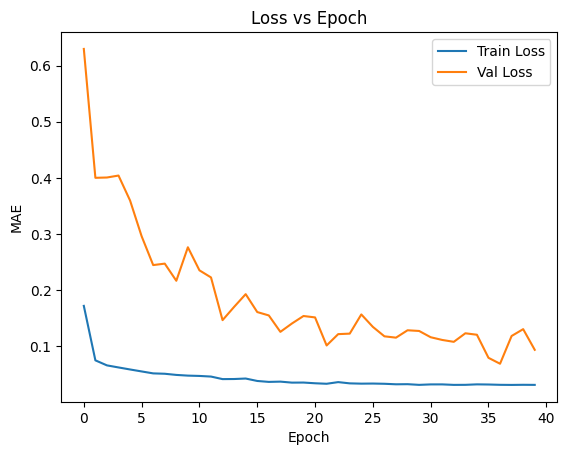

In [47]:
plt.plot(history_bbri.history['loss'], label='Train Loss')
plt.plot(history_bbri.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [48]:
y_pred_bbri = model_bbri.predict(X_test_bbri[..., np.newaxis]).flatten()
scaler_bbri = scalers['BBRI']
y_pred_unscaled_bbri = scaler_bbri.inverse_transform(y_pred_bbri.reshape(-1, 1)).flatten()
y_test_unscaled_bbri = scaler_bbri.inverse_transform(y_test_bbri.reshape(-1, 1)).flatten()

mae_bbri = mean_absolute_error(y_test_unscaled_bbri, y_pred_unscaled_bbri)
rmse_bbri = np.sqrt(mean_squared_error(y_test_unscaled_bbri, y_pred_unscaled_bbri))
mape_bbri = mean_absolute_percentage_error(y_test_unscaled_bbri, y_pred_unscaled_bbri) * 100

print('MAE Data Test BBRI : ', mae_bbri)
print('RMSE Data Test BBRI: ', rmse_bbri)
print('MAPE Data Test BBRI: ', mape_bbri)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
MAE Data Test BBRI :  50.548149146843905
RMSE Data Test BBRI:  75.56679488373533
MAPE Data Test BBRI:  1.2312418709616395


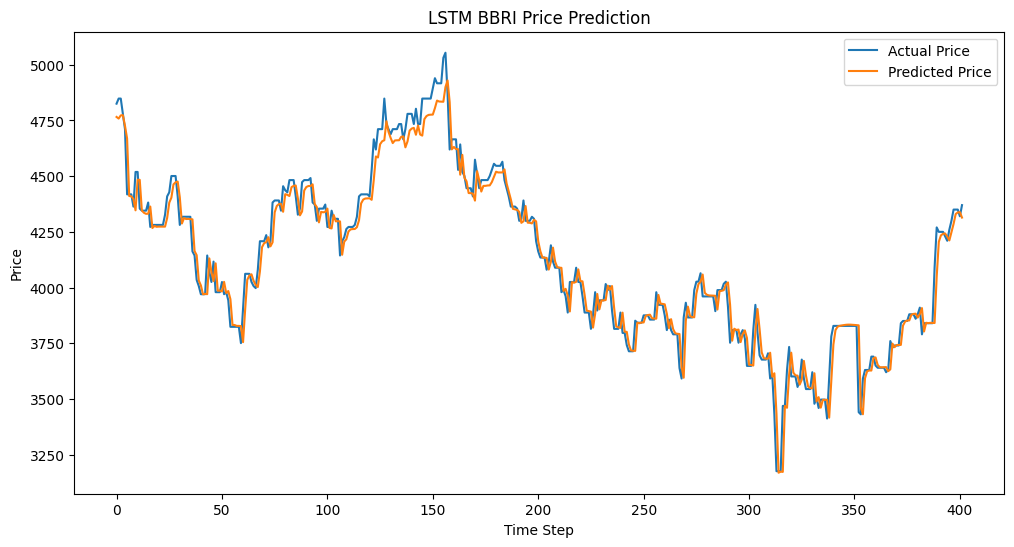

In [49]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_bbri, label='Actual Price')
plt.plot(y_pred_unscaled_bbri, label='Predicted Price')
plt.title('LSTM BBRI Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [50]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_bbri = data_bbri[-365:]

pred_dict_bbri = {}
for label, steps in time_span.items():
    X = recent_data_bbri.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_bbri.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_bbri = scaler_bbri.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_bbri[label] = float(unscaled_pred_bbri)

pred_dict_bbri

{'1d': 4351.668486595554,
 '1w': 4292.867474685515,
 '1m': 4186.562510004082,
 '3m': 4143.870561259251,
 '6m': 4132.8784190869}

## BMRI

In [51]:
window_size = 30
horizon = 1

data_bmri = df_scaled['BMRI'].values
X_train_bmri, y_train_bmri, X_val_bmri, y_val_bmri, X_test_bmri, y_test_bmri = split_data(data_bmri, window_size, horizon)

model_bmri = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_bmri.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_bmri.summary()
print("Model input shape:", model_bmri.input_shape)
print("Model output shape:", model_bmri.output_shape)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [52]:
history_bmri = model_bmri.fit(X_train_bmri[..., np.newaxis], y_train_bmri,
              validation_data=(X_val_bmri[..., np.newaxis], y_val_bmri),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.1868 - mape: 57.3839 - val_loss: 0.3648 - val_mape: 26.1365
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0576 - mape: 46.1651 - val_loss: 0.2975 - val_mape: 20.3731
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0514 - mape: 32.6673 - val_loss: 0.2773 - val_mape: 18.8283
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0460 - mape: 40.4260 - val_loss: 0.2908 - val_mape: 19.9824
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0465 - mape: 25.6061 - val_loss: 0.2645 - val_mape: 17.8200
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0442 - mape: 27.4481 - val_loss: 0.3018 - val_mape: 21.0050
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0412 - mape: 57.0472 - val_loss: 0.2844 - val_mape: 19.6390
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0386 - mape: 18.6277 - val_loss: 0.2739 - val_mape: 18.6457
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━

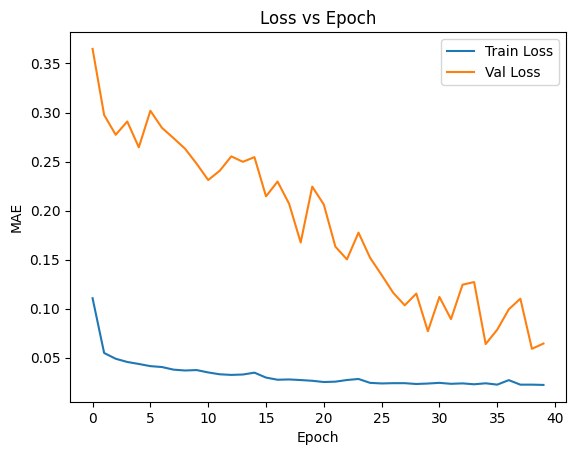

In [53]:
plt.plot(history_bmri.history['loss'], label='Train Loss')
plt.plot(history_bmri.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [54]:
y_pred_bmri = model_bmri.predict(X_test_bmri[..., np.newaxis]).flatten()
scaler_bmri = scalers['BMRI']
y_pred_unscaled_bmri = scaler_bmri.inverse_transform(y_pred_bmri.reshape(-1, 1)).flatten()
y_test_unscaled_bmri = scaler_bmri.inverse_transform(y_test_bmri.reshape(-1, 1)).flatten()

mae_bmri = mean_absolute_error(y_test_unscaled_bmri, y_pred_unscaled_bmri)
rmse_bmri = np.sqrt(mean_squared_error(y_test_unscaled_bmri, y_pred_unscaled_bmri))
mape_bmri = mean_absolute_percentage_error(y_test_unscaled_bmri, y_pred_unscaled_bmri) * 100

print('MAE Data Test BMRI : ', mae_bmri)
print('RMSE Data Test BMRI: ', rmse_bmri)
print('MAPE Data Test BMRI: ', mape_bmri)

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
MAE Data Test BMRI :  153.50719425334267
RMSE Data Test BMRI:  197.12022689980682
MAPE Data Test BMRI:  2.6290955525588866


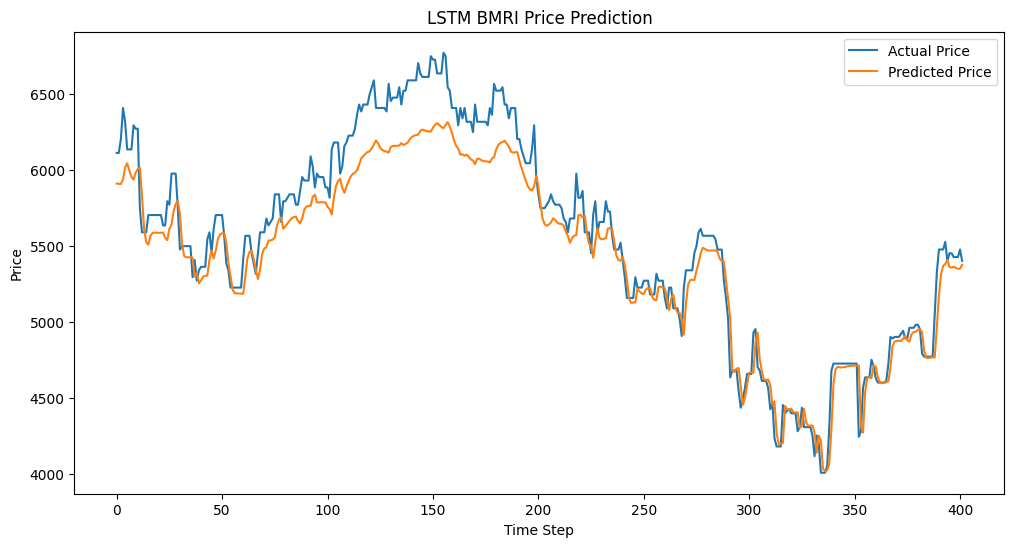

In [55]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_bmri, label='Actual Price')
plt.plot(y_pred_unscaled_bmri, label='Predicted Price')
plt.title('LSTM BMRI Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [56]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_bmri = data_bmri[-365:]

pred_dict_bmri = {}
for label, steps in time_span.items():
    X = recent_data_bmri.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_bmri.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_bmri = scaler_bmri.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_bmri[label] = float(unscaled_pred_bmri)

pred_dict_bmri

{'1d': 5348.664129059114,
 '1w': 5126.044848144009,
 '1m': 4826.174332611474,
 '3m': 4647.121543129276,
 '6m': 4609.406552572203}

## DSSA

In [57]:
window_size = 30
horizon = 1

data_dssa = df_scaled['DSSA'].values
X_train_dssa, y_train_dssa, X_val_dssa, y_val_dssa, X_test_dssa, y_test_dssa = split_data(data_dssa, window_size, horizon)

model_dssa = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model_dssa.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_dssa.summary()
print("Model input shape:", model_dssa.input_shape)
print("Model output shape:", model_dssa.output_shape)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [58]:
history_dssa = model_dssa.fit(X_train_dssa[..., np.newaxis], y_train_dssa,
              validation_data=(X_val_dssa[..., np.newaxis], y_val_dssa),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.1182 - mape: 26.3634 - val_loss: 0.0378 - val_mape: 72.0863
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0322 - mape: 7.3262 - val_loss: 0.0406 - val_mape: 69.3690
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0333 - mape: 7.6264 - val_loss: 0.0298 - val_mape: 66.3817
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0272 - mape: 6.1712 - val_loss: 0.0279 - val_mape: 60.3129
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 0.0274 - mape: 6.3665 - val_loss: 0.0346 - val_mape: 70.5951
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0251 - mape: 5.7441 - val_loss: 0.0295 - val_mape: 62.8532
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.0274 - mape: 6.2165 - val_loss: 0.0325 - val_mape: 64.0122
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0318 - mape: 7.1972 - val_loss: 0.0281 - val_mape: 59.1107
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 

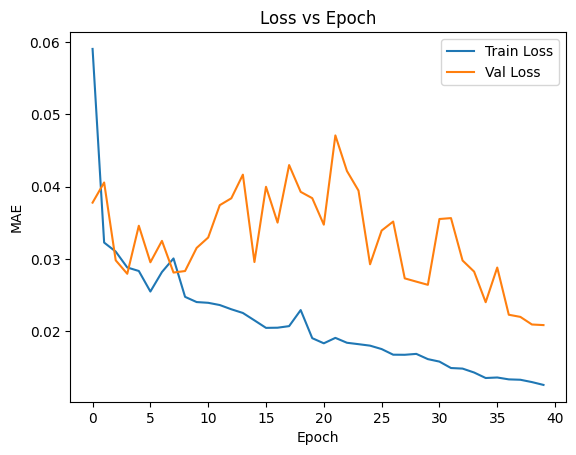

In [59]:
plt.plot(history_dssa.history['loss'], label='Train Loss')
plt.plot(history_dssa.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [60]:
y_pred_dssa = model_dssa.predict(X_test_dssa[..., np.newaxis]).flatten()
scaler_dssa = scalers['DSSA']
y_pred_unscaled_dssa = scaler_dssa.inverse_transform(y_pred_dssa.reshape(-1, 1)).flatten()
y_test_unscaled_dssa = scaler_dssa.inverse_transform(y_test_dssa.reshape(-1, 1)).flatten()

mae_dssa = mean_absolute_error(y_test_unscaled_dssa, y_pred_unscaled_dssa)
rmse_dssa = np.sqrt(mean_squared_error(y_test_unscaled_dssa, y_pred_unscaled_dssa))
mape_dssa = mean_absolute_percentage_error(y_test_unscaled_dssa, y_pred_unscaled_dssa) * 100

print('MAE Data Test DSSA : ', mae_dssa)
print('RMSE Data Test DSSA: ', rmse_dssa)
print('MAPE Data Test DSSA: ', mape_dssa)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
MAE Data Test DSSA :  1503.4446881801928
RMSE Data Test DSSA:  1999.1514161057094
MAPE Data Test DSSA:  4.204897811783974


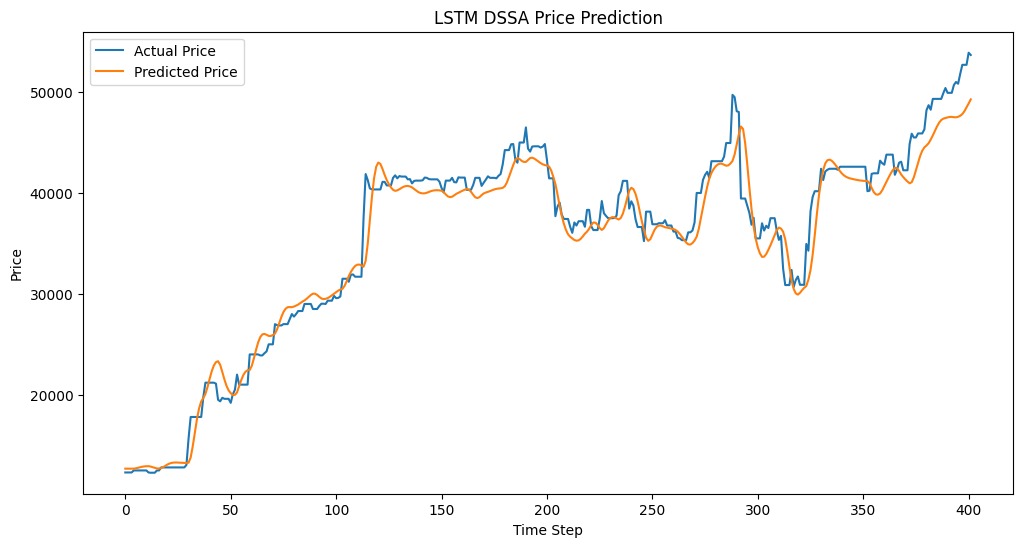

In [61]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_dssa, label='Actual Price')
plt.plot(y_pred_unscaled_dssa, label='Predicted Price')
plt.title('LSTM DSSA Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [62]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_dssa = data_dssa[-365:]

pred_dict_dssa = {}
for label, steps in time_span.items():
    X = recent_data_dssa.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_dssa.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_dssa = scaler_dssa.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_dssa[label] = float(unscaled_pred_dssa)

pred_dict_dssa

{'1d': 50143.04913696076,
 '1w': 47171.971173410515,
 '1m': 33264.87087942974,
 '3m': 36661.515818930166,
 '6m': 36207.96295964749}

## TLKM

In [63]:
window_size = 30
horizon = 1

data_tlkm = df_scaled['TLKM'].values
X_train_tlkm, y_train_tlkm, X_val_tlkm, y_val_tlkm, X_test_tlkm, y_test_tlkm = split_data(data_tlkm, window_size, horizon)

model_tlkm = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_tlkm.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_tlkm.summary()
print("Model input shape:", model_tlkm.input_shape)
print("Model output shape:", model_tlkm.output_shape)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [64]:
history_tlkm = model_tlkm.fit(X_train_tlkm[..., np.newaxis], y_train_tlkm,
              validation_data=(X_val_tlkm[..., np.newaxis], y_val_tlkm),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.3701 - mape: 62.7137 - val_loss: 0.1202 - val_mape: 16.9952
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1377 - mape: 38.5382 - val_loss: 0.1084 - val_mape: 14.9011
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1325 - mape: 35.8342 - val_loss: 0.1133 - val_mape: 15.1267
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1196 - mape: 36.3110 - val_loss: 0.0948 - val_mape: 12.7398
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1095 - mape: 33.6565 - val_loss: 0.1058 - val_mape: 14.0497
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1057 - mape: 31.1498 - val_loss: 0.1063 - val_mape: 13.9496
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0990 - mape: 31.5573 - val_loss: 0.1022 - val_mape: 13.4956
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0979 - mape: 25.4996 - val_loss: 0.0738 - val_mape: 10.0682
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━

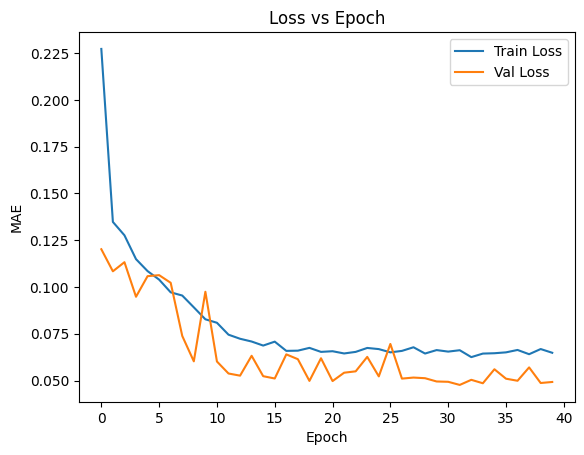

In [65]:
plt.plot(history_tlkm.history['loss'], label='Train Loss')
plt.plot(history_tlkm.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [66]:
y_pred_tlkm = model_tlkm.predict(X_test_tlkm[..., np.newaxis]).flatten()
scaler_tlkm = scalers['TLKM']
y_pred_unscaled_tlkm = scaler_tlkm.inverse_transform(y_pred_tlkm.reshape(-1, 1)).flatten()
y_test_unscaled_tlkm = scaler_tlkm.inverse_transform(y_test_tlkm.reshape(-1, 1)).flatten()

mae_tlkm = mean_absolute_error(y_test_unscaled_tlkm, y_pred_unscaled_tlkm)
rmse_tlkm = np.sqrt(mean_squared_error(y_test_unscaled_tlkm, y_pred_unscaled_tlkm))
mape_tlkm = mean_absolute_percentage_error(y_test_unscaled_tlkm, y_pred_unscaled_tlkm) * 100

print('MAE Data Test TLKM : ', mae_tlkm)
print('RMSE Data Test TLKM: ', rmse_tlkm)
print('MAPE Data Test TLKM: ', mape_tlkm)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
MAE Data Test TLKM :  32.173208663712686
RMSE Data Test TLKM:  47.804998286265594
MAPE Data Test TLKM:  1.1714163729034306


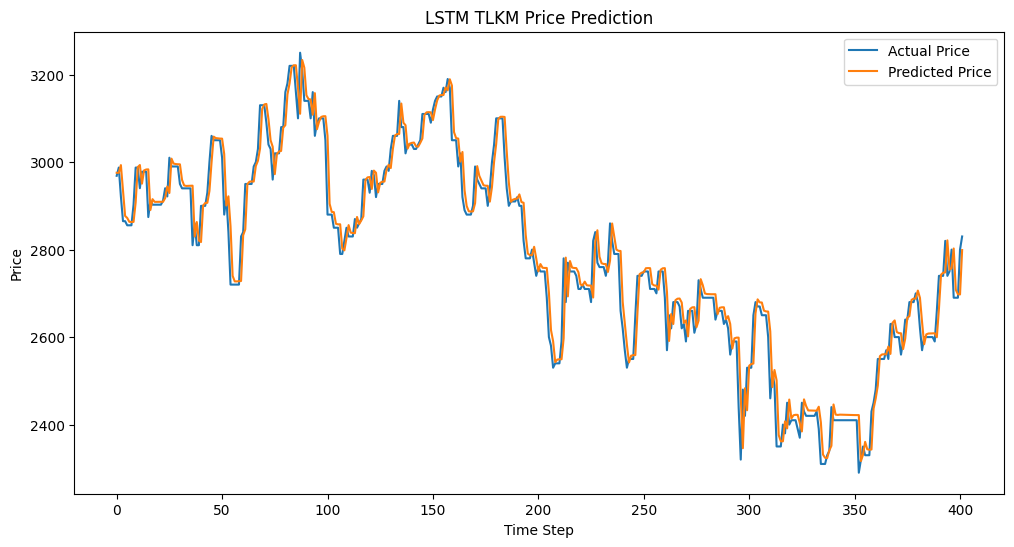

In [67]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_tlkm, label='Actual Price')
plt.plot(y_pred_unscaled_tlkm, label='Predicted Price')
plt.title('LSTM TLKM Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [68]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_tlkm = data_tlkm[-365:]

pred_dict_tlkm = {}
for label, steps in time_span.items():
    X = recent_data_tlkm.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_tlkm.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_tlkm = scaler_tlkm.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_tlkm[label] = float(unscaled_pred_tlkm)

pred_dict_tlkm

{'1d': 2833.3746311020577,
 '1w': 2867.7508774868597,
 '1m': 2984.950382630004,
 '3m': 3200.897624581471,
 '6m': 3359.559456122212}

## ASII

In [69]:
window_size = 30
horizon = 1

data_asii = df_scaled['ASII'].values
X_train_asii, y_train_asii, X_val_asii, y_val_asii, X_test_asii, y_test_asii = split_data(data_asii, window_size, horizon)

model_asii = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_asii.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_asii.summary()
print("Model input shape:", model_asii.input_shape)
print("Model output shape:", model_asii.output_shape)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [70]:
history_asii = model_asii.fit(X_train_asii[..., np.newaxis], y_train_asii,
              validation_data=(X_val_asii[..., np.newaxis], y_val_asii),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 0.3951 - mape: 98.4712 - val_loss: 0.1351 - val_mape: 83.5119
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1591 - mape: 70.0843 - val_loss: 0.1568 - val_mape: 79.3725
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1529 - mape: 61.3648 - val_loss: 0.1111 - val_mape: 72.2651
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1277 - mape: 58.4280 - val_loss: 0.0958 - val_mape: 63.3742
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.1269 - mape: 56.3452 - val_loss: 0.0909 - val_mape: 52.8463
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.1232 - mape: 53.8607 - val_loss: 0.0956 - val_mape: 53.1874
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1211 - mape: 50.9590 - val_loss: 0.0822 - val_mape: 52.4681
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1103 - mape: 50.9953 - val_loss: 0.0767 - val_mape: 51.2676
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━

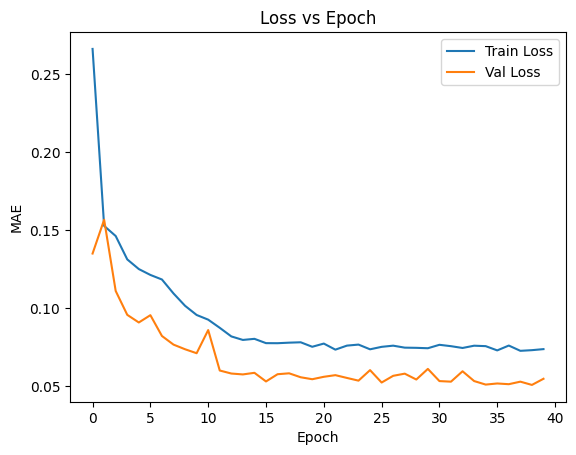

In [71]:
plt.plot(history_asii.history['loss'], label='Train Loss')
plt.plot(history_asii.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [72]:
y_pred_asii = model_asii.predict(X_test_asii[..., np.newaxis]).flatten()
scaler_asii = scalers['ASII']
y_pred_unscaled_asii = scaler_asii.inverse_transform(y_pred_asii.reshape(-1, 1)).flatten()
y_test_unscaled_asii = scaler_asii.inverse_transform(y_test_asii.reshape(-1, 1)).flatten()

mae_asii = mean_absolute_error(y_test_unscaled_asii, y_pred_unscaled_asii)
rmse_asii = np.sqrt(mean_squared_error(y_test_unscaled_asii, y_pred_unscaled_asii))
mape_asii = mean_absolute_percentage_error(y_test_unscaled_asii, y_pred_unscaled_asii) * 100

print('MAE Data Test ASII : ', mae_asii)
print('RMSE Data Test ASII: ', rmse_asii)
print('MAPE Data Test ASII: ', mape_asii)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
MAE Data Test ASII :  39.208835582828044
RMSE Data Test ASII:  63.54994606169875
MAPE Data Test ASII:  0.8770358661072335


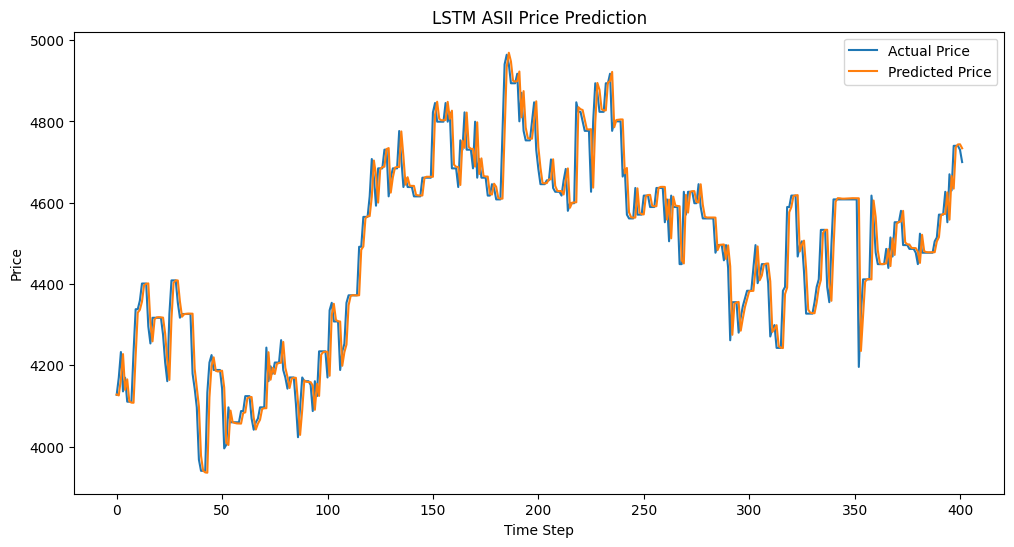

In [73]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_asii, label='Actual Price')
plt.plot(y_pred_unscaled_asii, label='Predicted Price')
plt.title('LSTM ASII Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [74]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_asii = data_asii[-365:]

pred_dict_asii = {}
for label, steps in time_span.items():
    X = recent_data_asii.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_asii.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_asii = scaler_asii.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_asii[label] = float(unscaled_pred_asii)

pred_dict_asii

{'1d': 4704.827708181528,
 '1w': 4726.692427853721,
 '1m': 4807.4125979431265,
 '3m': 5154.791072299749,
 '6m': 5920.200329755965}

## BBNI

In [75]:
window_size = 30
horizon = 1

data_bbni = df_scaled['BBNI'].values
X_train_bbni, y_train_bbni, X_val_bbni, y_val_bbni, X_test_bbni, y_test_bbni = split_data(data_bbni, window_size, horizon)

model_bbni = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_bbni.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_bbni.summary()
print("Model input shape:", model_bbni.input_shape)
print("Model output shape:", model_bbni.output_shape)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [76]:
history_bbni = model_bbni.fit(X_train_bbni[..., np.newaxis], y_train_bbni,
              validation_data=(X_val_bbni[..., np.newaxis], y_val_bbni),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.2569 - mape: 148.1489 - val_loss: 0.3383 - val_mape: 25.5923
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0888 - mape: 102.5262 - val_loss: 0.2157 - val_mape: 15.4340
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0805 - mape: 122.1570 - val_loss: 0.2578 - val_mape: 19.8590
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0690 - mape: 74.2566 - val_loss: 0.1956 - val_mape: 14.1478
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0718 - mape: 116.0084 - val_loss: 0.2240 - val_mape: 16.8670
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0663 - mape: 119.7571 - val_loss: 0.1724 - val_mape: 12.5016
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0669 - mape: 130.5515 - val_loss: 0.1376 - val_mape: 9.7198
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0609 - mape: 159.8628 - val_loss: 0.1494 - val_mape: 10.9539
Epoch 9/40
59/59 ━━━━━━━━━

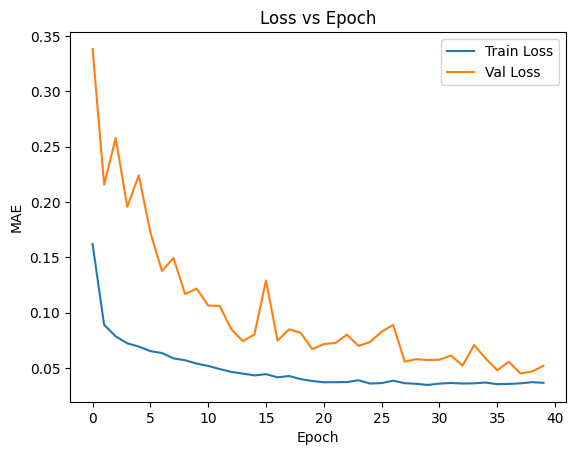

In [77]:
plt.plot(history_bbni.history['loss'], label='Train Loss')
plt.plot(history_bbni.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [78]:
y_pred_bbni = model_bbni.predict(X_test_bbni[..., np.newaxis]).flatten()
scaler_bbni = scalers['BBNI']
y_pred_unscaled_bbni = scaler_bbni.inverse_transform(y_pred_bbni.reshape(-1, 1)).flatten()
y_test_unscaled_bbni = scaler_bbni.inverse_transform(y_test_bbni.reshape(-1, 1)).flatten()

mae_bbni = mean_absolute_error(y_test_unscaled_bbni, y_pred_unscaled_bbni)
rmse_bbni = np.sqrt(mean_squared_error(y_test_unscaled_bbni, y_pred_unscaled_bbni))
mape_bbni = mean_absolute_percentage_error(y_test_unscaled_bbni, y_pred_unscaled_bbni) * 100

print('MAE Data Test BBNI : ', mae_bbni)
print('RMSE Data Test BBNI: ', rmse_bbni)
print('MAPE Data Test BBNI: ', mape_bbni)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
MAE Data Test BBNI :  66.46276673274254
RMSE Data Test BBNI:  93.38554673988196
MAPE Data Test BBNI:  1.4929698923027817


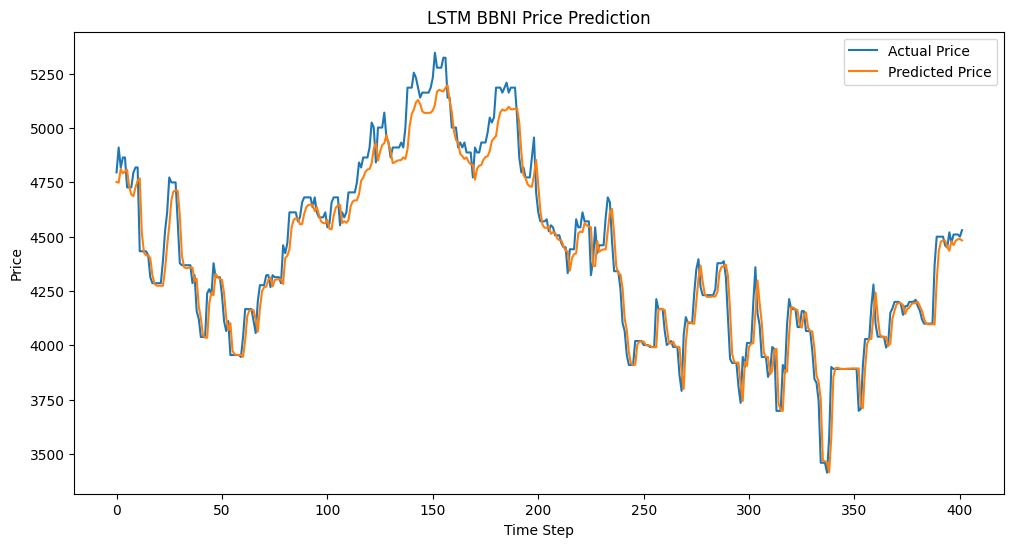

In [79]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_bbni, label='Actual Price')
plt.plot(y_pred_unscaled_bbni, label='Predicted Price')
plt.title('LSTM BBNI Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [80]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_bbni = data_bbni[-365:]

pred_dict_bbni = {}
for label, steps in time_span.items():
    X = recent_data_bbni.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_bbni.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_bbni = scaler_bbni.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_bbni[label] = float(unscaled_pred_bbni)

pred_dict_bbni

{'1d': 4500.922512302442,
 '1w': 4415.991676541588,
 '1m': 4212.0949822273105,
 '3m': 4039.2235661359514,
 '6m': 3980.1795367154587}

## ICBP

In [81]:
window_size = 30
horizon = 1

data_icbp = df_scaled['ICBP'].values
X_train_icbp, y_train_icbp, X_val_icbp, y_val_icbp, X_test_icbp, y_test_icbp = split_data(data_icbp, window_size, horizon)

model_icbp = Sequential([
    Input(shape=(window_size, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

model_icbp.compile(optimizer='adam', loss='mae', metrics=['mape'])

model_icbp.summary()
print("Model input shape:", model_icbp.input_shape)
print("Model output shape:", model_icbp.output_shape)

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Model input shape: (None, 30, 1)
Model output shape: (None, 1)


In [82]:
history_icbp = model_icbp.fit(X_train_icbp[..., np.newaxis], y_train_icbp,
              validation_data=(X_val_icbp[..., np.newaxis], y_val_icbp),
              epochs=40)

Epoch 1/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - loss: 0.3076 - mape: 86.1235 - val_loss: 0.2414 - val_mape: 26.0273
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.1210 - mape: 71.3574 - val_loss: 0.1457 - val_mape: 18.0177
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0997 - mape: 72.8470 - val_loss: 0.1213 - val_mape: 16.9390
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0918 - mape: 48.3362 - val_loss: 0.1336 - val_mape: 17.1105
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0884 - mape: 40.3625 - val_loss: 0.1114 - val_mape: 15.0942
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0775 - mape: 44.0664 - val_loss: 0.1063 - val_mape: 15.0589
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0807 - mape: 51.7762 - val_loss: 0.1022 - val_mape: 14.6613
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0759 - mape: 47.5150 - val_loss: 0.0989 - val_mape: 14.4159
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━

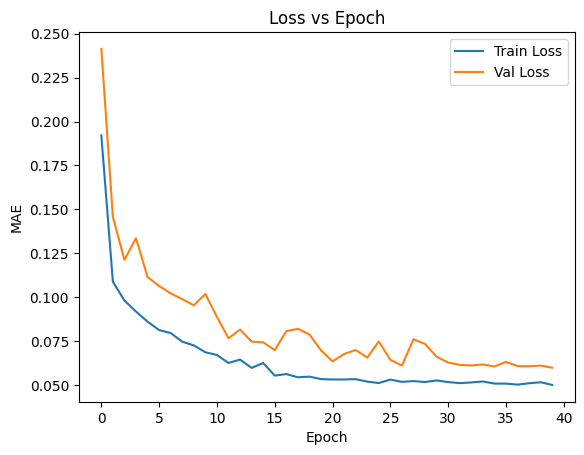

In [83]:
plt.plot(history_icbp.history['loss'], label='Train Loss')
plt.plot(history_icbp.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

In [84]:
y_pred_icbp = model_icbp.predict(X_test_icbp[..., np.newaxis]).flatten()
scaler_icbp = scalers['ICBP']
y_pred_unscaled_icbp = scaler_icbp.inverse_transform(y_pred_icbp.reshape(-1, 1)).flatten()
y_test_unscaled_icbp = scaler_icbp.inverse_transform(y_test_icbp.reshape(-1, 1)).flatten()

mae_icbp = mean_absolute_error(y_test_unscaled_icbp, y_pred_unscaled_icbp)
rmse_icbp = np.sqrt(mean_squared_error(y_test_unscaled_icbp, y_pred_unscaled_icbp))
mape_icbp = mean_absolute_percentage_error(y_test_unscaled_icbp, y_pred_unscaled_icbp) * 100

print('MAE Data Test ICBP : ', mae_icbp)
print('RMSE Data Test ICBP: ', rmse_icbp)
print('MAPE Data Test ICBP: ', mape_icbp)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
MAE Data Test ICBP :  110.75077736318408
RMSE Data Test ICBP:  166.79632709260332
MAPE Data Test ICBP:  0.9904851406519017


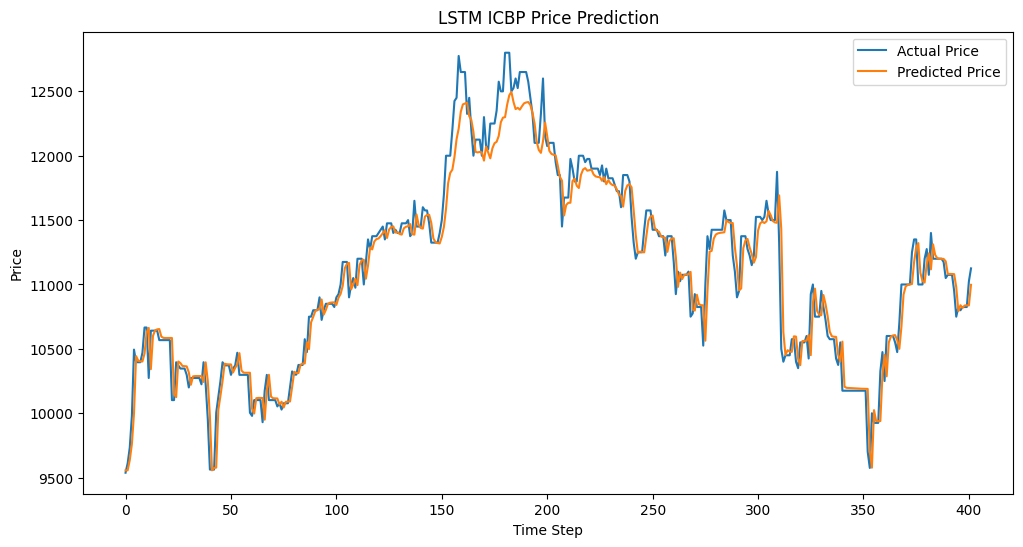

In [85]:
plt.figure(figsize=(12,6))
plt.plot(y_test_unscaled_icbp, label='Actual Price')
plt.plot(y_pred_unscaled_icbp, label='Predicted Price')
plt.title('LSTM ICBP Price Prediction')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

In [86]:
time_span = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
recent_data_icbp = data_icbp[-365:]

pred_dict_icbp = {}
for label, steps in time_span.items():
    X = recent_data_icbp.copy()
    for _ in range(steps):
        x_input = X[-365:].reshape(1, 365, 1)
        next_pred = model_icbp.predict(x_input, verbose=0)[0, 0]
        X = np.append(X, next_pred)

    # Ambil nilai terakhir dan kembalikan ke skala asli
    unscaled_pred_icbp = scaler_icbp.inverse_transform([[X[-1]]])[0, 0]
    pred_dict_icbp[label] = float(unscaled_pred_icbp)

pred_dict_icbp

{'1d': 11095.162280292607,
 '1w': 11085.645166773029,
 '1m': 11100.806592323926,
 '3m': 11108.637257046485,
 '6m': 11109.548680364427}

## All at once

In [ ]:
models = {}
history = {}
window_size = 30
horizon = 1

for ticker in tickers:
    print(f"Training model for {ticker}...")

    data = df_scaled[ticker].values
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, window_size, horizon)

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(window_size, 1)),
        LSTM(32),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mae', metrics=['mape'])
    h = model.fit(X_train[..., np.newaxis], y_train,
                  validation_data=(X_val[..., np.newaxis], y_val),
                  epochs=40)

    models[ticker] = model
    history[ticker] = h.history

Training model for BBCA...
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.3033 - mape: 80.5007 - val_loss: 0.1952 - val_mape: 17.0784
Epoch 2/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0616 - mape: 60.3029 - val_loss: 0.1708 - val_mape: 15.1667
Epoch 3/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0580 - mape: 63.2350 - val_loss: 0.0592 - val_mape: 5.8287
Epoch 4/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0464 - mape: 38.9036 - val_loss: 0.0918 - val_mape: 8.1084
Epoch 5/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0450 - mape: 30.8952 - val_loss: 0.0628 - val_mape: 5.6043
Epoch 6/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0426 - mape: 40.7312 - val_loss: 0.0792 - val_mape: 6.9518
Epoch 7/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0402 - mape: 27.6609 - val_loss: 0.0845 - val_mape: 7.4600
Epoch 8/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0402 - mape: 27.2959 - val_loss: 0.0703 - val_mape: 6.1269
Epoch 9/40
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/ste

In [ ]:
results = {}

for ticker in tickers:
    print(f"Evaluating model for {ticker}")
    model = models[ticker]
    data = df_scaled[ticker].values
    _, _, _, _, X_test, y_test = split_data(data, window_size, horizon)
    y_pred = model.predict(X_test[..., np.newaxis]).flatten()

    # Unscale hasil prediksi dan aktual
    scaler = scalers[ticker]
    y_pred_unscaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
    rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
    mape = mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled) * 100

    results[ticker] = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

pd.DataFrame(results).T

Evaluating model for BBCA
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Evaluating model for BYAN
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Evaluating model for TPIA
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Evaluating model for BBRI
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Evaluating model for BMRI
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Evaluating model for DSSA
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Evaluating model for TLKM
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Evaluating model for ASII
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Evaluating model for BBNI
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Evaluating model for ICBP
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


,MAE,RMSE,MAPE
BBCA,97.705709,134.474684,1.040160
BYAN,533.549518,639.629648,2.816114
TPIA,2434.950979,2584.476412,28.738458
BBRI,51.396010,76.439824,1.251385
BMRI,221.350053,280.552349,3.757454
DSSA,13535.762712,15016.611083,34.858274
TLKM,30.098016,47.497146,1.090713
ASII,41.080025,63.913668,0.917626
BBNI,63.620873,91.051413,1.431759
ICBP,110.242149,162.257946,0.986593


In [ ]:
futures = {'1d': 1, '1w': 7, '1m': 30, '3m': 90, '6m': 180}
predictions = {}

for ticker in tickers:
    print(f"Inferencing for {ticker}...")
    model = models[ticker]
    data = df_scaled[ticker].values
    recent_data = data[-window_size:]

    pred_dict = {}
    for label, steps in futures.items():
        X = recent_data.copy()
        for _ in range(steps):
            x_input = X[-window_size:].reshape(1, window_size, 1)
            next_pred = model.predict(x_input, verbose=0)[0, 0]
            X = np.append(X, next_pred)

        # Ambil nilai terakhir dan kembalikan ke skala asli
        unscaled_pred = scalers[ticker].inverse_transform([[X[-1]]])[0, 0]
        pred_dict[label] = unscaled_pred

    predictions[ticker] = pred_dict

pd.DataFrame(predictions)

Inferencing for BBCA...
Inferencing for BYAN...
Inferencing for TPIA...
Inferencing for BBRI...
Inferencing for BMRI...
Inferencing for DSSA...
Inferencing for TLKM...
Inferencing for ASII...
Inferencing for BBNI...
Inferencing for ICBP...


,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
1d,9449.864342,19239.075079,6123.894969,4343.811386,5306.597359,25491.229634,2827.149829,4692.160341,4505.613911,11076.190831
1w,9350.738514,18331.960499,5712.828525,4272.555404,5045.328084,24008.476188,2816.852851,4648.583630,4435.430368,10965.747124
1m,8947.496174,17558.467886,3597.743136,4091.303183,4627.774343,14872.326756,2799.712113,4470.751124,4251.876382,10730.988001
3m,8545.512426,17697.703903,2614.042142,3904.459944,4403.236711,9572.414999,2752.264161,4116.339044,4017.649184,10444.614506
6m,8355.467627,17697.566280,1830.110761,3749.125414,4337.250782,7105.427419,2627.589221,3733.582780,3846.510898,10291.482761


# Save Model and Scaler

In [88]:
model_dict = {
    'BBCA': model_bbca,
    'BYAN': model_byan,
    'TPIA': model_tpia,
    'BBRI': model_bbri,
    'BMRI': model_bmri,
    'DSSA': model_dssa,
    'TLKM': model_tlkm,
    'ASII': model_asii,
    'BBNI': model_bbni,
    'ICBP': model_icbp,
}

# Simpan models
os.makedirs('models', exist_ok=True)
for symbol, model in model_dict.items():
  # # Simpan model dalam format h5
  filename = f'models/{symbol}_model.h5'
  model.save(filename)

  # # Simpan model dalam format pickle
  filename = f'models/{symbol}_model.pkl'
  joblib.dump(model, filename)

  # Simpan model dalam format onnx
  model.output_names = ['output']
  # Mendapatkan input shape dari model
  input_shape = model.input_shape[1:] # Tidak Mengambil dimensi batch

  # Menetapkan input signature
  input_signature = [tf.TensorSpec(shape=[None] + list(input_shape), dtype=tf.float64, name='input')]

  # Konversi model Keras ke ONNX
  onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature)

  # Simpan model ONNX
  onnx.save_model(onnx_model, f"models/{symbol}_model.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c89fabbdc60>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c89fabbdc60>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c89fabbdc60>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c89fabbdc60>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c89fabbdc60>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7c89fabbdc60>

In [89]:
# Simpan scalers
os.makedirs('scalers', exist_ok=True)
for symbol, scaler in scalers.items():
  # Simpan scaler dalam format pkl
  filename = f'scalers/{symbol}_scaler.pkl'
  joblib.dump(scaler, filename)